# ME4 Machine Learning - Tutorial 9

In [1]:
import sys
# setting path
sys.path.append('..')

from helperlib import (
    mathfunctions as hmath, 
    arrayfunctions as harray) 

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# from sklearn import tree
from sklearn import ensemble
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(0)

# Don't show plots inline
%matplotlib agg

## 1. Clustering

### Make a test data set with 6 blobs.

In [2]:
n_samples = 1500
n_clusters = 6
X, y = make_blobs(n_samples=n_samples, centers=n_clusters, cluster_std=0.5)

### Apply k-means clustering algorith to cluster 6 regions.

In [3]:
km = KMeans(n_clusters=n_clusters)

### Make a plot of the predicted clusters.

In [4]:
pred_labels = km.fit_predict(X, y)

pred_clusters_dict = {i: [] for i in range(n_clusters)}
    
for i, cluster in enumerate(pred_labels):
    pred_clusters_dict[cluster].append(X[i])


701.1914050750593


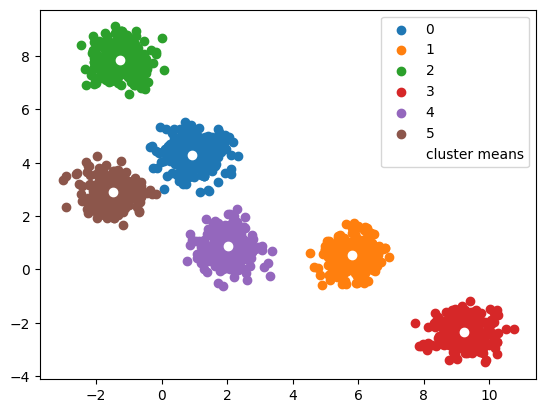

In [5]:
fig, ax = plt.subplots()
for cluster, X in pred_clusters_dict.items():
    x, y = np.array(X).T
    ax.scatter(x, y, label=str(cluster))
    
means = km.cluster_centers_
print(km.inertia_)
ax.scatter(means[:, 0], means[:, 1], label='cluster means', c='w')
ax.legend()
fig

## 2. Principal component analysis

### 2.1. Generate 500 samples from a 2D normal distribution centred at (0, 0) with a standard deviation of 0.3 and 0.1 in x and y respectively, which is then rotated around by 23 degrees.

Define a function to generate an arbitrary covariance matrix with a rotation:

In [6]:
def get_rotated_covar(sdx=1., sdy=1., theta_deg=0.):
    covar = np.array([[sdx**2, 0], [0, sdy**2]])
    rot_mat = hmath.get_rot_mat(theta_deg, 2)
    covar = hmath.mat_mul([rot_mat, covar, rot_mat.T])
    return covar


Produce a covariance matrix of sd 0.3 in x and 0.1 in y, then rotate by 23 degrees:

In [7]:
covar = get_rotated_covar(0.3, 0.1, 23)

In [8]:
X = np.random.multivariate_normal([0, 0], covar, size=500)

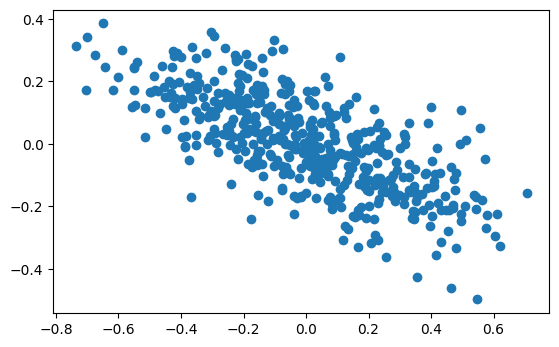

In [9]:
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1])
ax.set_aspect('equal')
fig

### 2.2. Perform pricipal component analysis.

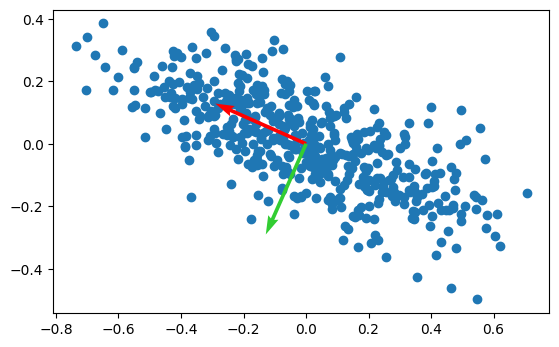

In [10]:
pca = PCA( n_components=2)
pred_labels = pca.fit(X)
origin = [[0, 0] for component in pca.components_]
plt.quiver(*origin, 
           pca.components_[:,0], 
           pca.components_[:,1], 
           color=['r','limegreen'], 
           scale=5)
fig

## 3. Submission

In [11]:
df = pd.read_csv('./volts.csv')
y1 = np.array(df['y1'])
y2 = np.array(df['y2'])
Y = np.array([y1, y2]).T
print (Y)

[[6.85998537 7.51385197]
 [2.08787739 6.65728753]
 [3.11536868 6.09980009]
 ...
 [3.16722864 2.71123112]
 [6.51148467 8.22991627]
 [2.49058066 2.52496488]]


### 3.1 Predict Output classes using unsupervised learning

In [12]:
n_clusters = 3
km = KMeans(n_clusters=n_clusters)
pred_labels = km.fit_predict(Y)

pred_clusters_dict = {i: [] for i in range(n_clusters)}
    
for i, cluster in enumerate(pred_labels):
    pred_clusters_dict[cluster].append(Y[i])

[[3.19462558 1.91429061]
 [7.19831173 7.70619219]
 [2.88507126 6.39672699]]


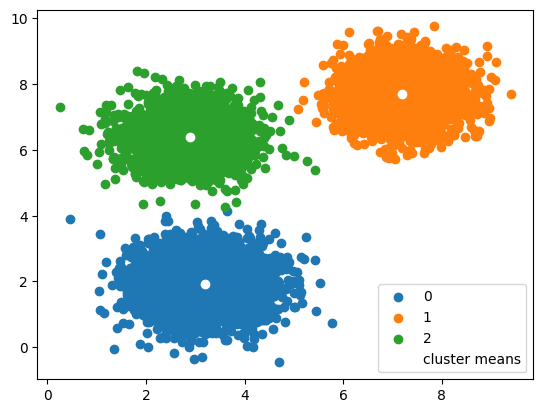

In [13]:
fig, ax = plt.subplots()
for cluster, X in pred_clusters_dict.items():
    x, y = np.array(X).T
    ax.scatter(x, y, label=str(cluster))
    
means = km.cluster_centers_
print(means)
ax.scatter(means[:, 0], means[:, 1], label='cluster means', c='w')
ax.legend()
fig

### 3.2. Train a classifier to predict general output for this system.

Use a random forest with 100 trees each and a maximum depth of 20. Plot the resulting decision function as a contour plot, with the colour indicating the class as a function of the two inputs x 1and x 2in the range 0 to 10v.

In [14]:
x1 = np.array(df['x1'])
x2 = np.array(df['x2'])
X = np.array([x1, x2]).T
y = pred_labels


In [15]:
def gen_sample_grid(npx=200, npy=200, limit=1):
  x1line = np.linspace(0, limit, npx)
  x2line = np.linspace(0, limit, npy)
  x1grid, x2grid = np.meshgrid(x1line, x2line)
  Xgrid = np.array([x1grid, x2grid]).reshape([2,npx*npy]).T
  return Xgrid,x1line,x2line

In [19]:
Xgrid,x1line,x2line = gen_sample_grid(200,200,10)

In [34]:
c = np.random.randint(0, 3, y.shape)
n_clusters = c.max() - c.min() + 1


3

[[9.88362e-01 9.98364e-01 6.44924e-01 1.00000e+00]
 [7.29909e-01 2.12759e-01 3.33861e-01 1.00000e+00]
 [1.46200e-03 4.66000e-04 1.38660e-02 1.00000e+00]]


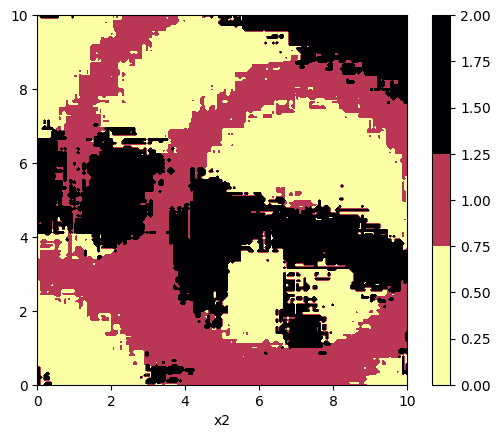

In [41]:
rf = ensemble.RandomForestClassifier(n_estimators=100,max_depth=20)
rf.fit(X, y)

prob = rf.predict_proba(Xgrid)
discrete_prob = [np.argmax(p) for p in prob]
discrete_prob_plot = np.array(discrete_prob).reshape(200,200)

fig, ax = plt.subplots()
cmap = plt.get_cmap('inferno_r', n_clusters)
print(cmap.colors)
contour = plt.contourf(x1line, x2line, discrete_prob_plot, cmap=cmap)

cbar = fig.colorbar(contour, ax=ax)
tick_locs = np.linspace(c.min(), c.max(), 2 * n_clusters + 1)[1::2]
cbar_tick_label = np.arange(c.min(), c.max() + 1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(cbar_tick_label)

ax.set_xlabel('x1')
ax.set_xlabel('x2')
ax.set_aspect('equal')
fig